In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#read worksheet into dataframe

df_main = pd.read_excel('Sample - Superstore.xls', sheet_name='Orders')
df_returns = pd.read_excel('Sample - Superstore.xls', sheet_name='Returns')

### Merge Return Orders Data to Main Dataset

In [3]:
df_merge = df_main.merge(df_returns, how='left', on="Order ID")
df_merge.sample(5)

,Row ID,Order ID,Order Date,Ship Date,Days to Arrive,Ship Mode,Customer ID,Customer Name,Segment,Country,...,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Returned
1352,6739,CA-2013-123358,2013-04-11,2013-04-18,7,Standard Class,BT-11680,Brian Thompson,Consumer,United States,...,West,OFF-BI-10000069,Office Supplies,Binders,"GBC Prepunched Paper, 19-Hole, for Binding Sys...",48.032,4,0.2,15.6104,NaN
3210,1678,CA-2013-122728,2013-05-19,2013-05-25,6,Standard Class,EB-13930,Eric Barreto,Consumer,United States,...,West,OFF-PA-10004040,Office Supplies,Paper,Universal Premium White Copier/Laser Paper (20...,17.940,3,0.0,8.7906,NaN
2841,8806,US-2014-100398,2014-08-20,2014-08-24,4,Standard Class,DO-13435,Denny Ordway,Consumer,United States,...,West,OFF-BI-10002133,Office Supplies,Binders,"Wilson Jones Elliptical Ring 3 1/2"" Capacity B...",102.720,3,0.2,37.2360,NaN
4003,273,CA-2012-155334,2012-07-30,2012-07-31,1,First Class,HA-14920,Helen Andreada,Consumer,United States,...,West,FUR-FU-10003274,Furniture,Furnishings,Regeneration Desk Collection,5.280,3,0.0,2.3232,NaN
7752,6295,CA-2011-141152,2011-09-16,2011-09-19,3,First Class,RF-19345,Randy Ferguson,Corporate,United States,...,East,OFF-BI-10002931,Office Supplies,Binders,"Avery Trapezoid Extra Heavy Duty 4"" Binders",33.552,1,0.2,12.5820,NaN


### Replace Values in Returned Column with 1s and 0s

In [4]:
df_merge.fillna(0, inplace=True)
df_merge.replace('Yes', 1, inplace=True)

### Check for NaN Values and Duplicated Rows

In [5]:
df_merge.isna().values.any()

False

In [6]:
df_merge.duplicated().value_counts()
df_cleaned = df_merge

### Checking the Count Distribution of Output Variables

In [7]:
order_count = df_merge[['Order ID', 'Returned']].groupby('Returned').nunique()
print(f'The total number of rows for non-return orders is: {order_count["Order ID"][0]}')
print(f'The total number of rows for returned orders is: {order_count["Order ID"][1]}\n')

product_count = df_merge[['Order ID', 'Returned']].groupby('Returned').count()
print(f'The total number of rows for non-return products is: {product_count["Order ID"][0]}')
print(f'The total number of rows for returned products is: {product_count["Order ID"][1]}')

The total number of rows for non-return orders is: 4713
The total number of rows for returned orders is: 296

The total number of rows for non-return products is: 9194
The total number of rows for returned products is: 800


### Features Selection

In [8]:
data = df_cleaned[['Returned', 'Sales', 'Profit', 'State', 'Sub-Category']]
data

,Returned,Sales,Profit,State,Sub-Category
0,0,48.712,5.4801,Washington,Chairs
1,0,17.940,4.6644,Washington,Art
2,0,242.940,4.8588,Washington,Storage
3,0,12.624,-2.5248,Texas,Storage
4,0,221.980,62.1544,Oklahoma,Phones
...,...,...,...,...,...
9989,0,823.960,51.4975,Florida,Phones
9990,0,15.984,4.9950,Florida,Paper
9991,0,71.120,22.0472,Indiana,Furnishings
9992,0,259.960,124.7808,Indiana,Phones


### Class Selection for Sub-Categories & States

In [9]:
state_list = ['Minnesota','California', 'New York', 'Washington', 'Michigan', 'Indiana', 'Virginia', 'Georgia', 'Kentucky']
subcat_list = ['Appliances','Copiers', 'Phones', 'Accessories', 'Paper', 'Furnishings', 'Storage', 'Chairs']

df_ml = data[(data['State'].isin(state_list)) & (data['Sub-Category'].isin(subcat_list))]

print(df_ml.Returned.value_counts())
df_ml.shape

0    2477
1     322
Name: Returned, dtype: int64


(2799, 5)

# Balancing the Inbalance Outcome Class

### Split the majority (non-return) and the minority (returned)  class

In [10]:
#Store data associated with minority class in dataframe t1

class_1 = df_ml[df_ml.Returned == 1]
print(class_1['State'].value_counts())
print(class_1['Sub-Category'].value_counts())
class_1.shape

California    203
New York       48
Washington     43
Georgia         8
Virginia        7
Michigan        5
Indiana         3
Kentucky        3
Minnesota       2
Name: State, dtype: int64
Paper          87
Furnishings    53
Phones         45
Chairs         41
Storage        35
Accessories    31
Appliances     25
Copiers         5
Name: Sub-Category, dtype: int64


(322, 5)

In [11]:
#Store data associated with majority class in dataframe t2

class_0 = df_ml[df_ml.Returned == 0]
print(class_0['State'].value_counts())
print(class_0['Sub-Category'].value_counts())


California    997
New York      612
Washington    258
Michigan      149
Virginia      122
Georgia       108
Indiana        97
Kentucky       82
Minnesota      52
Name: State, dtype: int64
Paper          550
Furnishings    380
Storage        374
Phones         364
Accessories    320
Chairs         264
Appliances     193
Copiers         32
Name: Sub-Category, dtype: int64


### Downsample majority class dataset using random stratified sampling

In [12]:
class_0_dwn = class_0.groupby('Sub-Category', group_keys=False).apply(lambda x: x.sample(frac=0.323, random_state=1))
class_0_dwn = class_0_dwn.reset_index()
class_0_dwn.State.value_counts()

California    323
New York      193
Washington     89
Georgia        40
Indiana        38
Virginia       37
Michigan       35
Kentucky       29
Minnesota      16
Name: State, dtype: int64

### Concatenate (Merge) downsampled majority class and minority class

In [13]:
a = pd.concat([class_0_dwn, class_1], axis=0)
a = a.reset_index(drop=True)
a.drop(columns='index', inplace=True)
a

,Returned,Sales,Profit,State,Sub-Category
0,0,843.90,371.3160,Washington,Accessories
1,0,49.98,8.4966,California,Accessories
2,0,428.40,89.9640,Washington,Accessories
3,0,50.00,10.5000,Washington,Accessories
4,0,239.94,26.3934,Washington,Accessories
...,...,...,...,...,...
1117,1,363.92,-31.8430,California,Chairs
1118,1,50.22,2.0088,California,Storage
1119,1,83.42,24.1918,California,Appliances
1120,1,15.70,7.0650,California,Paper


In [14]:
# a.to_csv('superstore_1600.csv')

### Split Into Output Variables and Input Variables

In [15]:
y = a.iloc[:,0]
X = a.iloc[:,1:]

### upsampling minority class using SMOTENC

In [16]:
from imblearn.over_sampling import SMOTENC
oversample = SMOTENC(categorical_features=[2, 3], random_state=42)
X, y = oversample.fit_resample(X, y)

In [17]:
X['Sub-Category'].value_counts()

Paper          389
Furnishings    254
Phones         230
Storage        216
Accessories    190
Chairs         182
Appliances     122
Copiers         17
Name: Sub-Category, dtype: int64

# Runing ML in Pipeline 

In [18]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

In [19]:
#Feature Scaling on Numeric Features
numeric_features = ["Sales", "Profit"]
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

#One-Hot Encode on Categorical Features
categorical_features = ["State", "Sub-Category"]
categorical_transformer = OneHotEncoder(drop='first')


#Column Transformer with Mixed Types
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [20]:
lr_pipe = Pipeline(
    steps=[("preprocessor", preprocessor) , ("classifier", LogisticRegression(C=100, max_iter=50,
                                                                             solver='newton-cg', random_state=1))]
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1, stratify=y)

lr_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Sales', 'Profit']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['State', 'Sub-Category'])])),
                ('classifier',
                 LogisticRegression(C=100, max_iter=50, random_state=1,
                                    solver='newton-cg'))])

In [57]:
X_train.to_csv('X_train.csv')
y_train.to_csv('y_train.csv')
X_test.to_csv('X_test.csv')
y_test.to_csv('y_test.csv')

In [21]:
from sklearn import set_config

set_config(display="diagram")
lr_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Sales', 'Profit']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['State', 'Sub-Category'])])),
                ('classifier',
                 LogisticRegression(C=100, max_iter=50, random_state=1,
                                    solver='newton-cg'))])

In [22]:
y_pred = lr_pipe.predict(X_test)

# Confusion Matrix

In [23]:
from sklearn.metrics import confusion_matrix, classification_report
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

print(classification_report(y_test, y_pred))

[[49 31]
 [11 69]]
              precision    recall  f1-score   support

           0       0.82      0.61      0.70        80
           1       0.69      0.86      0.77        80

    accuracy                           0.74       160
   macro avg       0.75      0.74      0.73       160
weighted avg       0.75      0.74      0.73       160



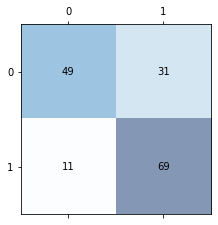

In [24]:
fig, ax=plt.subplots(figsize=(3.5, 3.5))
ax.matshow(confmat, 
          cmap=plt.cm.Blues, alpha=0.5)

for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i,
        s = confmat[i,j], va='center', ha='center')
        

plt.show()

# Predict

In [25]:
input_array = np.array([[118.00, 20.06, 'Washington', 'Accessories']])
input_df = pd.DataFrame(input_array, columns=['Sales', 'Profit', 'State', 'Sub-Category'])

y_pred = lr_pipe.predict(input_df)
y_pred[0] 

1

In [26]:
y_pred[122:130]

array([], dtype=int64)

In [27]:
y_prob = lr_pipe.predict_proba(input_df)
y_prob[:,1][0]

0.5164116258889726

# Running ML without Pipeline

## One-Hot Encode Nomimal Data using Pandas

In [28]:
x1 = pd.get_dummies(X, drop_first=True)
x1

,Sales,Profit,State_Georgia,State_Indiana,State_Kentucky,State_Michigan,State_Minnesota,State_New York,State_Virginia,State_Washington,Sub-Category_Appliances,Sub-Category_Chairs,Sub-Category_Copiers,Sub-Category_Furnishings,Sub-Category_Paper,Sub-Category_Phones,Sub-Category_Storage
0,843.900000,371.316000,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,49.980000,8.496600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,428.400000,89.964000,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,50.000000,10.500000,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,239.940000,26.393400,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,71.276161,24.903229,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1596,23.504557,11.335963,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
1597,110.126576,10.456494,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1598,394.285324,43.685805,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


## Standardise Numerical Data - Profit and Sales

In [29]:
sc= StandardScaler()
mms = MinMaxScaler()

X_std = sc.fit_transform(X.iloc[:,0:2])  #standardized the training data using sample mean and sd
X_std = pd.DataFrame(X_std, columns =['Sales', 'Profit'])
X_std

X2_std = mms.fit_transform(X.iloc[:,0:2])  #standardized the training data using sample mean and sd
X2_std = pd.DataFrame(X2_std, columns =['Sales', 'Profit'])
X2_std
X_std.head()

,Sales,Profit
0,0.706979,0.840406
1,-0.265414,-0.161329
2,0.198075,0.063600
3,-0.265389,-0.155798
4,-0.032751,-0.111917


Text(0.5, 1.0, 'Min-max Normalized')

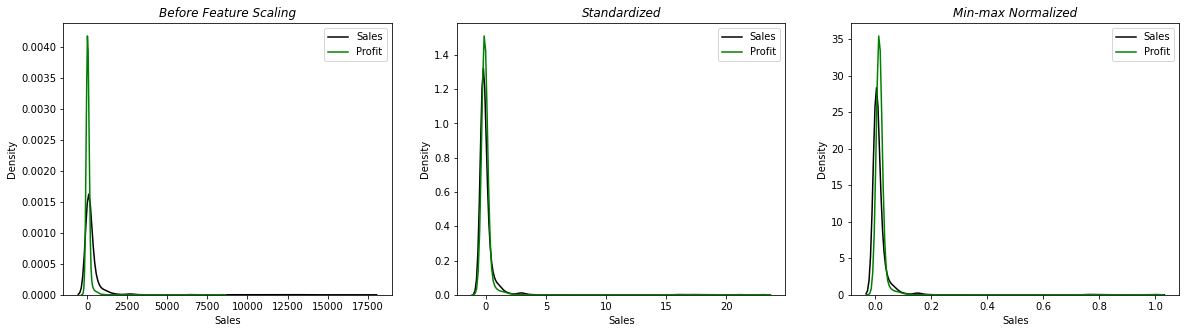

In [30]:
import seaborn as sns 

fig, (ax1, ax2, ax3) = plt.subplots(ncols= 3, figsize =(20, 5))
t = X.iloc[:,0:2]

sns.kdeplot(t['Sales'], ax=ax1, color ='black', label= 'Sales')
sns.kdeplot(t['Profit'], ax=ax1, color ='g', label= 'Profit')
# sns.kdeplot(t['Days to Arrive'], ax=ax1, color ='b')
ax1.legend()
ax1.set_title('Before Feature Scaling', fontstyle='italic')

sns.kdeplot(X_std['Sales'], ax=ax2, color ='black', label= 'Sales')
sns.kdeplot(X_std['Profit'], ax=ax2, color ='g', label= 'Profit')
# sns.kdeplot(X_std['Days to Arrive'], ax=ax2, color ='b')
ax2.set_title('Standardized', fontstyle='italic')
ax2.legend()

sns.kdeplot(X2_std['Sales'], ax=ax3, color ='black', label= 'Sales')
sns.kdeplot(X2_std['Profit'], ax=ax3, color ='g', label= 'Profit')
# sns.kdeplot(X2_std['Days to Arrive'], ax=ax3, color ='b')
ax3.legend()
ax3.set_title('Min-max Normalized', fontstyle='italic')


#sns.kdeplot(standard_df['x3'], ax=ax2, color ='b')

## Merge Standardized Data and Encoded Data

In [31]:
X = pd.merge(X_std, x1.iloc[:, 2:], left_index=True, right_index=True)
X

,Sales,Profit,State_Georgia,State_Indiana,State_Kentucky,State_Michigan,State_Minnesota,State_New York,State_Virginia,State_Washington,Sub-Category_Appliances,Sub-Category_Chairs,Sub-Category_Copiers,Sub-Category_Furnishings,Sub-Category_Paper,Sub-Category_Phones,Sub-Category_Storage
0,0.706979,0.840406,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,-0.265414,-0.161329,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.198075,0.063600,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,-0.265389,-0.155798,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,-0.032751,-0.111917,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,-0.239330,-0.116031,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1596,-0.297841,-0.153490,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
1597,-0.191746,-0.155918,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1598,0.156291,-0.064173,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1, stratify=y)

# Tuning Hyperparameters

In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

lr = LogisticRegression()

solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
max_iter= [50, 100]

grid = dict(solver=solvers,penalty=penalty,C=c_values, max_iter=max_iter)
cv = StratifiedKFold(n_splits=10,shuffle=True, random_state=1)
grid_search1 = GridSearchCV(estimator=lr, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy' ,error_score=0)
grid_search2 = GridSearchCV(estimator=lr, param_grid=grid, n_jobs=-1, cv=cv, scoring='recall' ,error_score=0)
grid_result1 = grid_search1.fit(X_train, y_train)
grid_result2 = grid_search2.fit(X_train, y_train)

print("Best accuracy score: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
print("Best recall score: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))

means = grid_result2.cv_results_['mean_test_score']
params = grid_result2.cv_results_['params']
for mean, param in zip(means, params):
    print("%f with: %r" % (mean, param))


Best accuracy score: 0.638889 using {'C': 100, 'max_iter': 50, 'penalty': 'l2', 'solver': 'newton-cg'}
Best recall score: 0.798611 using {'C': 100, 'max_iter': 50, 'penalty': 'l2', 'solver': 'newton-cg'}
0.798611 with: {'C': 100, 'max_iter': 50, 'penalty': 'l2', 'solver': 'newton-cg'}
0.798611 with: {'C': 100, 'max_iter': 50, 'penalty': 'l2', 'solver': 'lbfgs'}
0.798611 with: {'C': 100, 'max_iter': 50, 'penalty': 'l2', 'solver': 'liblinear'}
0.798611 with: {'C': 100, 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.798611 with: {'C': 100, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.798611 with: {'C': 100, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.798611 with: {'C': 10, 'max_iter': 50, 'penalty': 'l2', 'solver': 'newton-cg'}
0.798611 with: {'C': 10, 'max_iter': 50, 'penalty': 'l2', 'solver': 'lbfgs'}
0.798611 with: {'C': 10, 'max_iter': 50, 'penalty': 'l2', 'solver': 'liblinear'}
0.798611 with: {'C': 10, 'max_iter': 100, 'penalty': 'l2', 'solver': '

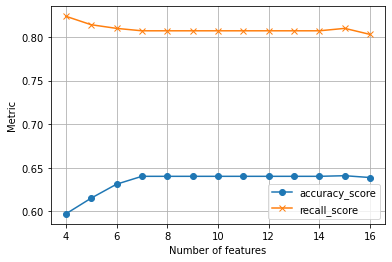

In [34]:
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import accuracy_score, recall_score
from sklearn.linear_model import LogisticRegression

sbs_acc = []
sbs_rec = []
feat_list = []
k_features = [i for i in range(4,17)]

solvers = ['lbfgs']
penalty = ['l2']
c_values = [100]
max_iter= [50]


grid = dict(solver=solvers,penalty=penalty,C=c_values, max_iter=max_iter)


for i in range(4, 17):
    lr = LogisticRegression(penalty='l2', C=0.1, random_state=1, solver='liblinear', max_iter=50)
    sfs = SequentialFeatureSelector(lr, n_features_to_select=i, direction='backward', cv=cv)
    sfs.fit(X_train, y_train)

    feats = sfs.get_feature_names_out()
    feat_list.append(feats)

    lr = LogisticRegression()

    grid_search1 = GridSearchCV(estimator=lr, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy' ,error_score=0)
    grid_search2 = GridSearchCV(estimator=lr, param_grid=grid, n_jobs=-1, cv=cv, scoring='recall' ,error_score=0)
    grid_result1 = grid_search1.fit(X_train[feats], y_train)
    grid_result2 = grid_search2.fit(X_train[feats], y_train)


    sbs_acc.append(grid_result1.best_score_)
    sbs_rec.append(grid_result2.best_score_)


    
plt.plot(k_features, sbs_acc, marker='o', label='accuracy_score')
plt.plot(k_features, sbs_rec, marker='x', label='recall_score')
plt.legend()

plt.ylabel('Metric')
plt.xlabel('Number of features')
plt.grid()
plt.show()


In [35]:
feat_list[3]

array(['State_Georgia', 'State_Indiana', 'State_Kentucky',
       'State_Michigan', 'State_Minnesota', 'State_New York',
       'State_Virginia'], dtype=object)

In [36]:
print(f'accuracy: {sbs_acc[3]}, recall: {sbs_rec[3]}')

accuracy: 0.6402777777777777, recall: 0.8069444444444445


# Logistic Regression Model

In [37]:
lr = grid_result2.best_estimator_
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [38]:
feature_names = list(X_test.columns)
feature_names

['Sales',
 'Profit',
 'State_Georgia',
 'State_Indiana',
 'State_Kentucky',
 'State_Michigan',
 'State_Minnesota',
 'State_New York',
 'State_Virginia',
 'State_Washington',
 'Sub-Category_Appliances',
 'Sub-Category_Chairs',
 'Sub-Category_Copiers',
 'Sub-Category_Furnishings',
 'Sub-Category_Paper',
 'Sub-Category_Phones',
 'Sub-Category_Storage']

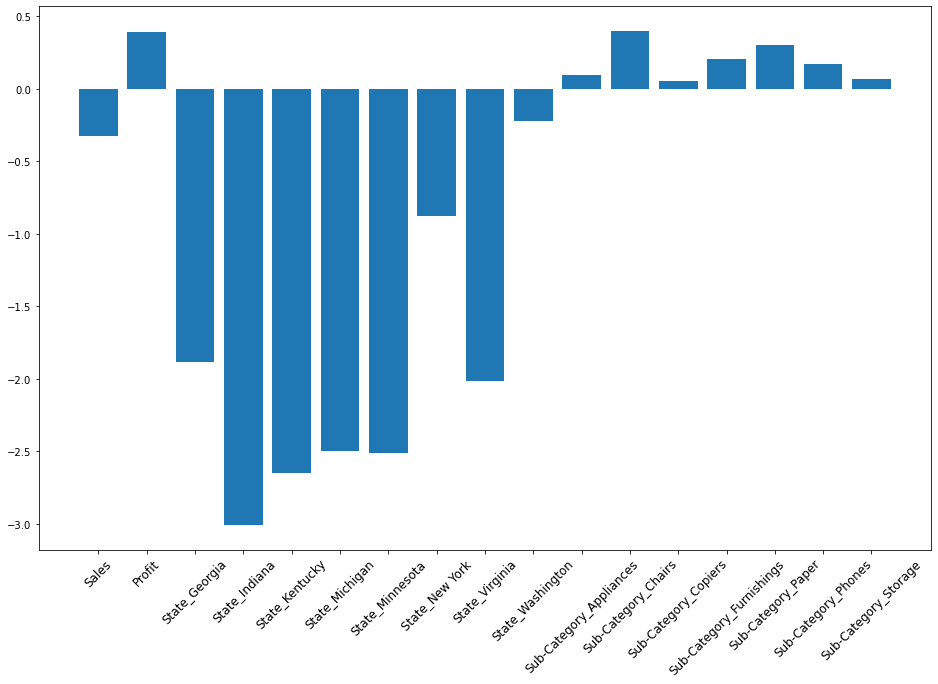

In [39]:
# plot feature importance
importance = lr.coef_[0]
plt.figure(figsize=(16,10))
plt.bar(feature_names, importance)
plt.xticks(fontsize=12, rotation=45)
plt.show()

## Confusion Matrix

[[49 31]
 [11 69]]


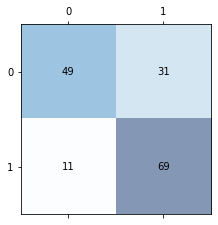

In [40]:
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

fig, ax=plt.subplots(figsize=(3.5, 3.5))
ax.matshow(confmat, 
          cmap=plt.cm.Blues, alpha=0.5)

for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i,
        s = confmat[i,j], va='center', ha='center')
        

plt.show()

In [41]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.61      0.70        80
           1       0.69      0.86      0.77        80

    accuracy                           0.74       160
   macro avg       0.75      0.74      0.73       160
weighted avg       0.75      0.74      0.73       160



In [42]:
# input_array = np.array([[118.00, 20.06, 'Washington', 'Accessories']])
# input_df = pd.DataFrame(input_array, columns=['Sales', 'Profit', 'State', 'Sub-Category'])

# y_pred = lr.predict(input_df)
# y_pred[0] 

# Learning Curve

In [43]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
# lr = LogisticRegression(C=100, random_state=1)
desired_acc = [0.8 for x in range(1, 11)]

train_sizes, train_scores, test_scores = learning_curve(estimator=lr, X=X_train, y=y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=cv, n_jobs=1, scoring='accuracy', random_state=1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

train_sizes, train_scores_rec, test_scores_rec = learning_curve(estimator=lr, X=X_train, y=y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=cv, n_jobs=1, scoring='recall', random_state=1)
train_mean_rec = np.mean(train_scores_rec, axis=1)
train_std_rec = np.std(train_scores_rec, axis=1)
test_mean_rec = np.mean(test_scores_rec, axis=1)
test_std_rec = np.std(test_scores_rec, axis=1)

C:\Users\khchu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\khchu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\khchu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\khchu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\khchu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\khchu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\khchu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\khchu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\khchu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\khchu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\khchu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\khchu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\khchu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\khchu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

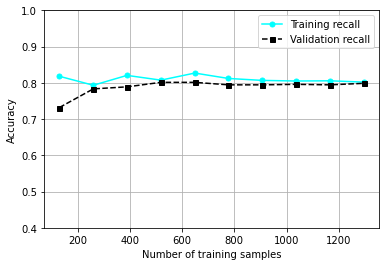

In [44]:
plt.plot(train_sizes, train_mean_rec, color='cyan', marker='o', markersize =5, label='Training recall')
# plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha= 0.15, color='blue')

plt.plot(train_sizes, test_mean_rec, color='black', linestyle='--', marker='s', markersize=5, label='Validation recall')
# plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')


plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.ylim([0.4, 1.0])
plt.show()


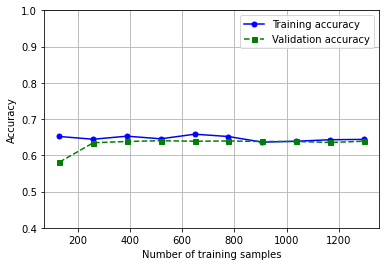

In [45]:
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize =5, label='Training accuracy')

# plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha= 0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')

# plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')


plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.ylim([0.4, 1.0])
plt.show()


# Decision Tree Model

In [46]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [47]:
dtc = DecisionTreeClassifier()

max_depth = [4, 5, 6]
criterion = ['gini', 'entropy']


grid = dict(max_depth=max_depth,criterion=criterion)
grid_search = GridSearchCV(estimator=dtc, param_grid=grid, n_jobs=-1, scoring='recall', cv=cv,error_score=0)

grid_result = grid_search.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.834722 using {'criterion': 'entropy', 'max_depth': 4}


In [48]:
dtc = grid_result.best_estimator_
dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)

In [49]:
import graphviz 
dot_data = tree.export_graphviz(dtc, out_file=None, feature_names=X_train.columns, class_names=['No', 'Yes'],
                                filled=True, rounded=True, special_characters=True) 
graph = graphviz.Source(dot_data) 
graph.render("tree") 

'tree.pdf'

              precision    recall  f1-score   support

           0       0.81      0.49      0.61        80
           1       0.63      0.89      0.74        80

    accuracy                           0.69       160
   macro avg       0.72      0.69      0.67       160
weighted avg       0.72      0.69      0.67       160



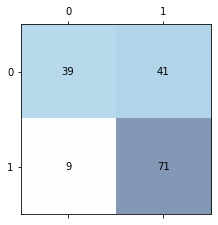

In [50]:
print(classification_report(y_test, y_pred))

confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)

fig, ax=plt.subplots(figsize=(3.5, 3.5))
ax.matshow(confmat, 
          cmap=plt.cm.Blues, alpha=0.5)

for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i,
        s = confmat[i,j], va='center', ha='center')
        

plt.show()

In [51]:
feature_labels = X.columns[:]
importances = dtc.feature_importances_
indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f+1, 30, feature_labels[indices[f]], importances[indices[f]]))

 1) State_Indiana                  0.220463
 2) State_Michigan                 0.179873
 3) State_Kentucky                 0.165273
 4) State_New York                 0.162208
 5) Profit                         0.117452
 6) Sales                          0.078447
 7) Sub-Category_Furnishings       0.044696
 8) Sub-Category_Phones            0.031588
 9) State_Minnesota                0.000000
10) State_Georgia                  0.000000
11) Sub-Category_Storage           0.000000
12) State_Washington               0.000000
13) Sub-Category_Appliances        0.000000
14) Sub-Category_Chairs            0.000000
15) Sub-Category_Copiers           0.000000
16) Sub-Category_Paper             0.000000
17) State_Virginia                 0.000000


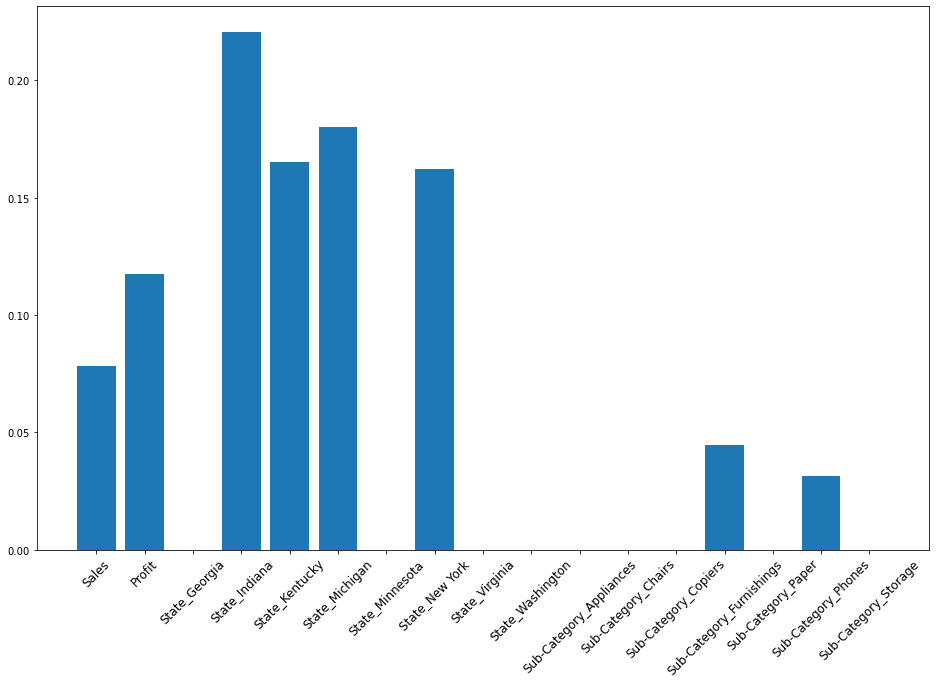

In [52]:
plt.figure(figsize=(16,10))
plt.bar(feature_labels, importances)
plt.xticks(fontsize=12, rotation=45)
plt.show()

# Random Forest Classifier

In [53]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
n_estimators = [10, 50 ,100, 1000]
max_features = ['sqrt', 'log2']

grid = dict(n_estimators=n_estimators,max_features=max_features)

grid_search = GridSearchCV(estimator=rfc, param_grid=grid, n_jobs=-1, cv=cv, scoring='recall',error_score=0)
grid_result = grid_search.fit(X_train, y_train)

print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")  #grid_result.best_params_

Best: 0.6902777777777779 using {'max_features': 'log2', 'n_estimators': 1000}


In [54]:
rfc = grid_result.best_estimator_
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

In [55]:
print(classification_report(y_test, y_pred))
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

              precision    recall  f1-score   support

           0       0.73      0.71      0.72        80
           1       0.72      0.74      0.73        80

    accuracy                           0.73       160
   macro avg       0.73      0.73      0.72       160
weighted avg       0.73      0.72      0.72       160

[[57 23]
 [21 59]]


## Feature Importance with Random Forest

In [56]:
feature_labels = X.columns[:]
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f+1, 30, feature_labels[indices[f]], importances[indices[f]]))

 1) Profit                         0.385521
 2) Sales                          0.376966
 3) State_New York                 0.028328
 4) State_Washington               0.024179
 5) State_Indiana                  0.020100
 6) State_Georgia                  0.018906
 7) Sub-Category_Furnishings       0.017978
 8) Sub-Category_Appliances        0.017163
 9) State_Virginia                 0.016754
10) State_Michigan                 0.016210
11) State_Kentucky                 0.015960
12) Sub-Category_Phones            0.013881
13) Sub-Category_Storage           0.012821
14) Sub-Category_Paper             0.012149
15) Sub-Category_Chairs            0.010471
16) State_Minnesota                0.010131
17) Sub-Category_Copiers           0.002482
